# Introduction

# Imports

In [1]:
import pandas as pd
import os
import numpy as np
import json
import random

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from scipy import stats
from scipy.stats import pearsonr
from scipy.interpolate import CubicSpline

#Modelling
import statsmodels.api as sm
import statsmodels.formula.api as smf

#Sklearn
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

#Resampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

#Self-written helpers
from helpers.nationality import *
from helpers.clustering import *
from helpers.nandropping import *
from helpers.ethnicity import *
from helpers.modelling import *

# Data
## How datasets are joined

### Movie dataset and Character dataset
We join the two datasets on the `freebase_movie_id`.

### Character dataset and Oscar dataset
Oscar dataset does not have `freebase_movie_id` or `freebase_actor_id`. We instead use `parsed_actor_name` and `movie_identifier`. `parsed_actor_name` will be unique for each movie as we drop actors if they share `parsed_actor_name` from playing another character in the same movie. `movie_identifier` is a combination of `parsed_movie_name` and `release_year`. This is unique as we drop movies that share `movie_identifier`.

### Resulting dataset from previous steps and IMDb dataset
We join these datasets using a combination of `parsed_movie_name` and `release_year` as primary key.
<br><br><br>
The resulting dataset after the entire pipeline is run is written to `cache/data.csv`, ready for use in P3.

In [2]:
%run data_pipeline.ipynb

########## Data pipeline ##########

Preparing CMU data
379 movies shared both name and release year, dropping
314 movies had actors with the same name, dropping

Merging Oscar dataset, after merge:
Number of different Oscar nominated movies in dataset: 952 in total 63968 different movies
Number of different Oscar nominated actors in dataset: 801 in total 134907 different actors
Number of Oscar nominated rows: 1443

Merging IMDb dataset, after merge:
Number of movies with ratings: 36760
Oscar nominated movies with rating: 939
Number of rows in data before cleaning:  443504
Number of rows in data after cleaning:  23819
Number of rows where age is < 0: 7 . Dropping these rows

FINAL STATE OF DATA
Number of rows:  23812
Number of different Oscar nominated movies in dataset: 394 in total 5987 different movies
Number of different Oscar nominated actors in dataset: 284 in total 2959 different actors
Number of Oscar nominated rows: 519
Processing done, dataset written to cache/data.csv


In [3]:
# Read data
df = pd.read_csv('cache/data.csv', sep=',', index_col=0)
unclean_df = pd.read_csv('cache/unclean_data.csv', sep=',', index_col=0)

In [4]:
genres_df = pd.read_parquet('cache/genres.parquet')
languages_df = pd.read_parquet('cache/languages.parquet')
countries_df = pd.read_parquet('cache/countries.parquet')

## Variables

In [5]:
ethnicity_map = {
 '/m/0dryh9k': 'Indian',
 '/m/0x67': 'Black',
 '/m/041rx': 'Jewish',
 '/m/02w7gg': 'English',
 '/m/033tf_': 'Irish_Americans',
 '/m/0xnvg': 'Italian_Americans',
 '/m/02ctzb': 'White_people',
 '/m/07hwkr': 'White_Americans',
 '/m/07bch9': 'Scottish_Americans',
 '/m/03bkbh': 'Irish_people',
 '/m/0d7wh': 'British',
 '/m/03ts0c': 'French',
 '/m/0222qb': 'Italians',
 '/m/01rv7x': 'Tamil'
}

# fix random seed for reproducibility
np.random.seed(42)
random.seed(42)

## Effect of dropping NaN values

### Country

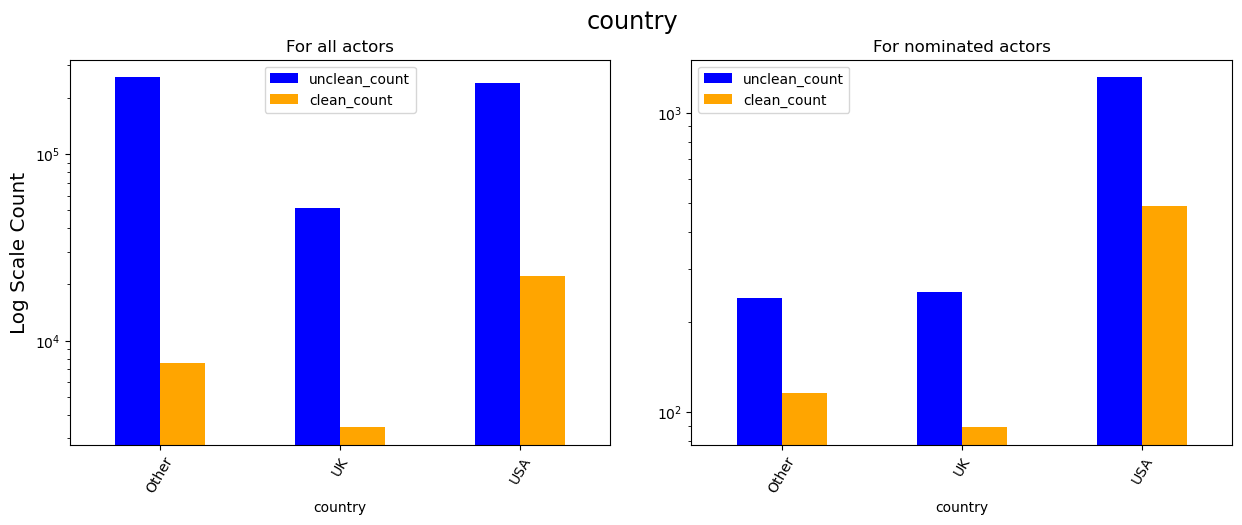

In [6]:
#Create copies for handling country data
country_df = df.copy()
country_unclean_df = unclean_df.copy()

#Fix apostrophes in countries column
country_df['countries'] = df['countries'].apply(lambda row: row.replace("'", '"')).apply(json.loads)
country_unclean_df['countries'] = unclean_df['countries'].apply(lambda row: row.replace("'", '"')).apply(json.loads)

#Extract all countries associated to a given movie
country_df = country_df.explode(column='countries').rename(columns={'countries':'country'}).reset_index()
country_unclean_df = country_unclean_df.explode(column='countries').rename(columns={'countries':'country'}).reset_index()
display_cleaning_shift_plot(country_df, country_unclean_df, "country", ['United States of America', 'United Kingdom'],False, {'United States of America': 'USA', 'United Kingdom' : 'UK'}, rotation = 60, savefile="plots/nandropping_plots/country.jpg")

As seen in this plot, cleaning the data has a pretty significant effect on the distribution of data, in terms of the presence of nominated movies. Before cleaning, the number of movies from other countries was comparable to the number of movies from USA. After cleaning this was no longer true.

Looking at the nominated movies, the number of nominated movies from other countries or the UK never compared to the number of nominated movies from the US.

In conclusion, this means that the data cleaning process targets more the group of movies that are unnominated and from countries other than the US.

### Ethnicity

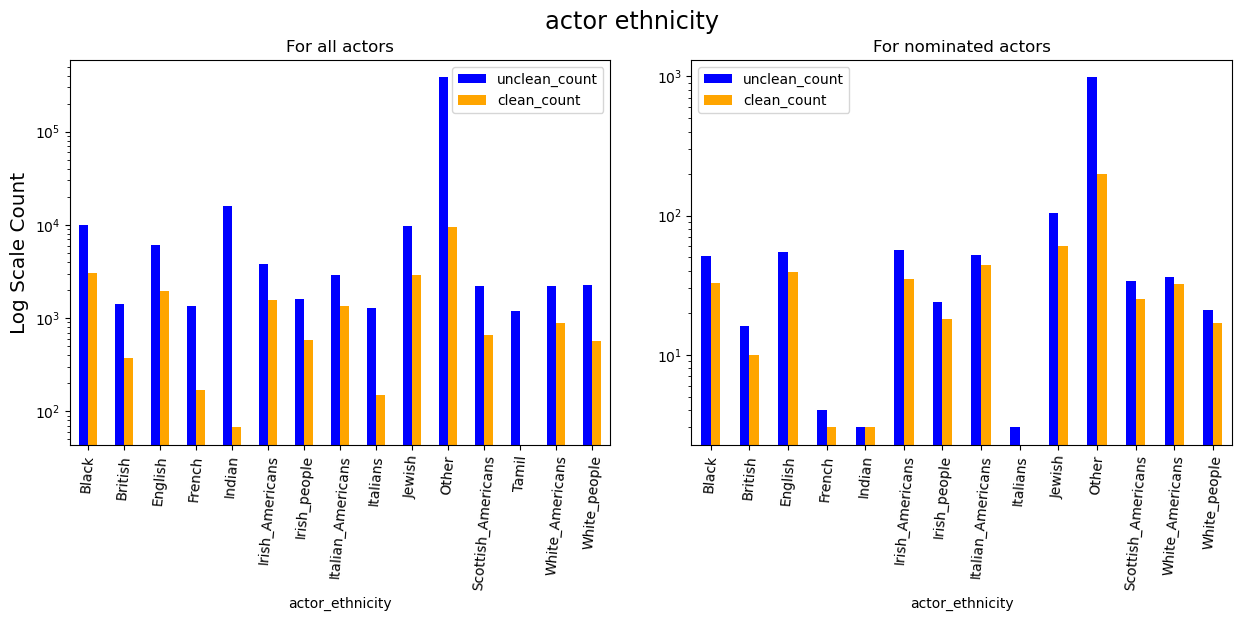

In [7]:
#Create copies for handling ethnicity data
ethnicity_df = df.copy()
ethnicity_unclean_df = unclean_df.copy()

#Map the known map values, "Other" if we don't know
ethnicity_df['actor_ethnicity'] = ethnicity_df['actor_ethnicity'].map(ethnicity_map).fillna("Other")
ethnicity_unclean_df['actor_ethnicity'] = ethnicity_unclean_df['actor_ethnicity'].map(ethnicity_map).fillna("Other")

display_cleaning_shift_plot(ethnicity_df, ethnicity_unclean_df, 'actor_ethnicity', rotation = 85, savefile="plots/nandropping_plots/ethnicity.jpg")

In is noteworthy, that for both all actors and nominated actors the largest unkiwn group before and after dropping is "other".

In terms of ethnicity diversity, most nominated movies only suffer a small dropoff of ethnical diversity. 
However, considering all movies, indian actors which represented the biggest knows ethnicity of actors suffers a big dropoff. There are no known Tamil actors left after dropping the values. A lot of data on French and Italian actors is also lost.

In conclusion while the data cleaning generally has a small impact, some ethnicities suffer a lot. This indicates that the data we are using may already be biased against some groups

### IMDb ratings

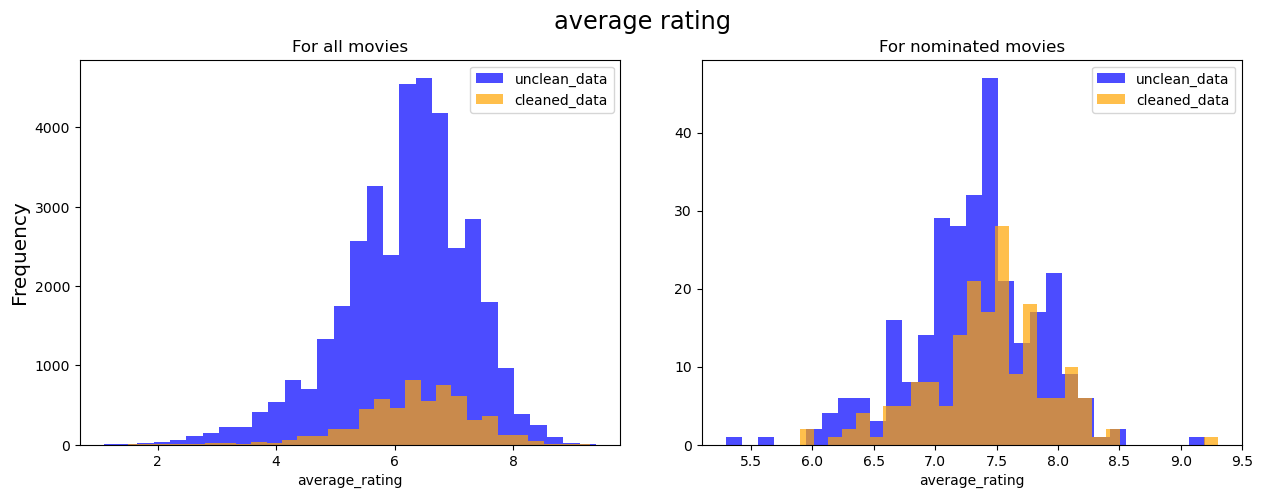

Kolmogorov-Smirnov test for the average_rating distributions before and after data cleaning for all data
Statistic: 0.06461772087618933 ; p-value: 3.9376274994600676e-19

Kolmogorov-Smirnov test for the average_rating distributions before and after data cleaning for nominated data
Statistic: 0.10274894271434064 ; p-value: 0.1762379219985301


In [8]:
imdb_df = df.drop_duplicates(subset='movie_identifier', keep='first')
imdb_unclean_df = unclean_df.drop_duplicates(subset='movie_identifier', keep='first')

display_cleaning_shift_plot_cont(imdb_df, imdb_unclean_df, "average_rating", "movies", 30, 30, savefile="plots/nandropping_plots/ratings.jpg")

The Kolmogorov-Smirnov indicates that for all the movies dropping the NaN values significantly changed the distributions rating, but for the distribution of ratings for nominated movies it did not. This is in tune with our previous notes that dropping data mostly "hurts" the general data but not necessarily the target group we are researching.

The distributions being different for all data however do not seem too significant with the eye. The rating distributions for both similarly peak around 7.

### Height

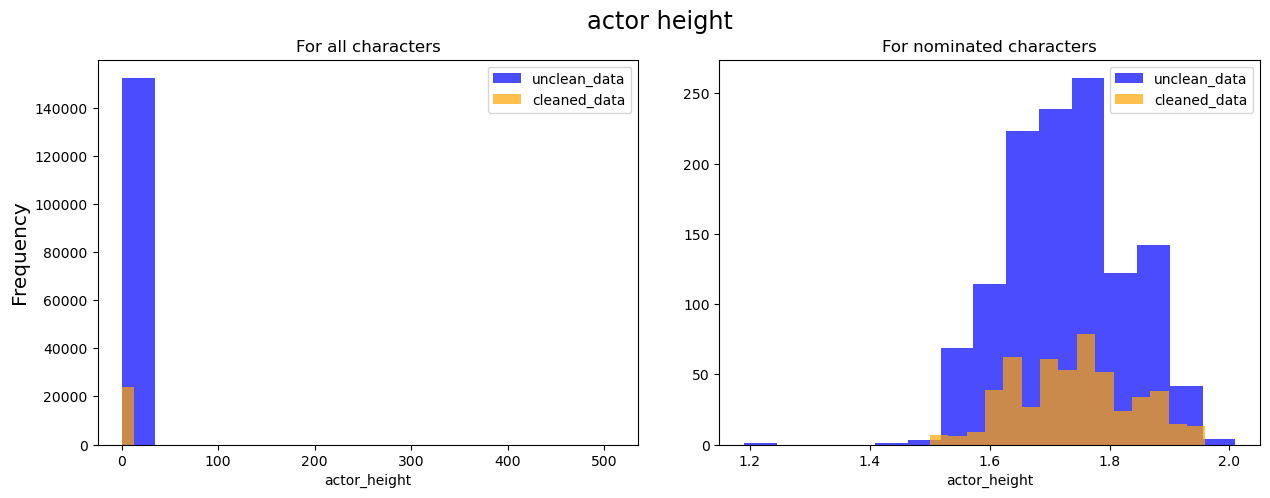

Kolmogorov-Smirnov test for the actor_height distributions before and after data cleaning for all data
Statistic: 0.0453313782769274 ; p-value: 3.26141375901912e-37

Kolmogorov-Smirnov test for the actor_height distributions before and after data cleaning for nominated data
Statistic: 0.06871085483802247 ; p-value: 0.06062138766816438


In [9]:
display_cleaning_shift_plot_cont(df, unclean_df, 'actor_height', "characters", 15, 15, savefile="plots/nandropping_plots/height.jpg")

Again, the Kolmogorov-Smirnov indicates that for all the movies dropping the NaN values significantly changed the distributions rating, but for the distribution of ratings for nominated movies it did not.

### Age

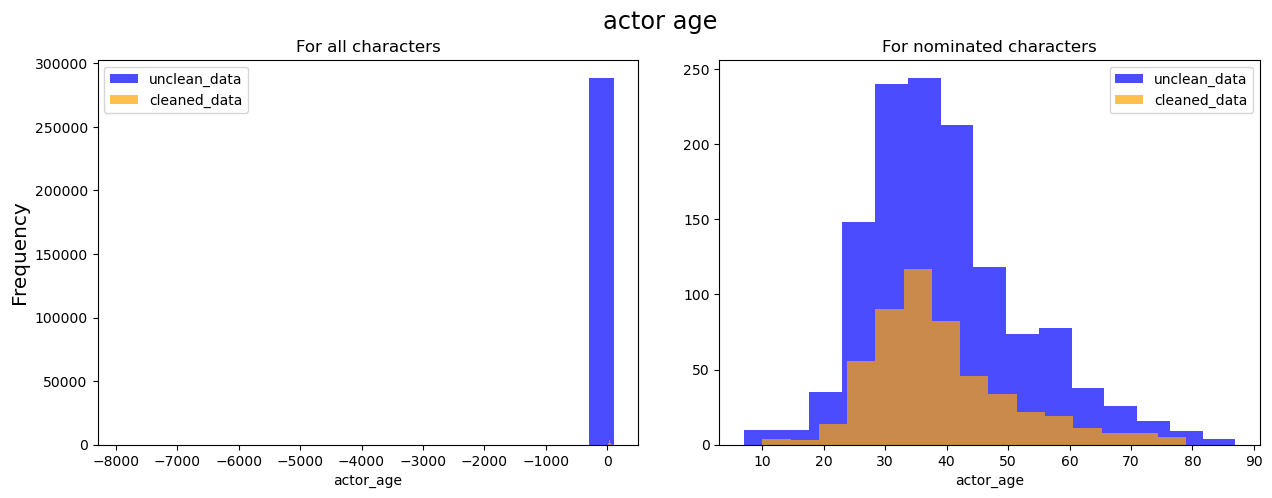

Kolmogorov-Smirnov test for the actor_age distributions before and after data cleaning for all data
Statistic: 0.03271068956335296 ; p-value: 7.001131753264708e-21

Kolmogorov-Smirnov test for the actor_age distributions before and after data cleaning for nominated data
Statistic: 0.043725600574831006 ; p-value: 0.4666259046232366


In [10]:
display_cleaning_shift_plot_cont(df, unclean_df, 'actor_age', "characters", 20, 15, savefile="plots/nandropping_plots/age.jpg")

Unclean data seems to have negative values, for nominated data the distribution does not change

### Gender

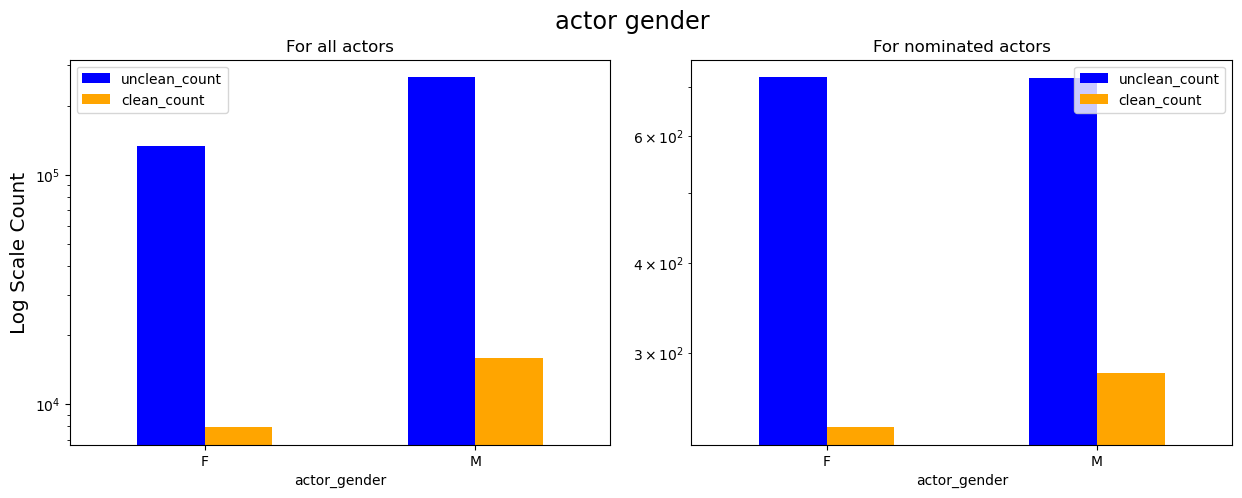

In [11]:
display_cleaning_shift_plot(df, unclean_df, 'actor_gender',['M', 'F'], True, rotation = 0, savefile="plots/nandropping_plots/gender.jpg")

The cleaning removes more female actors than male actors. Since the oscar nominations are gendered this will not affect the research too much

### Year

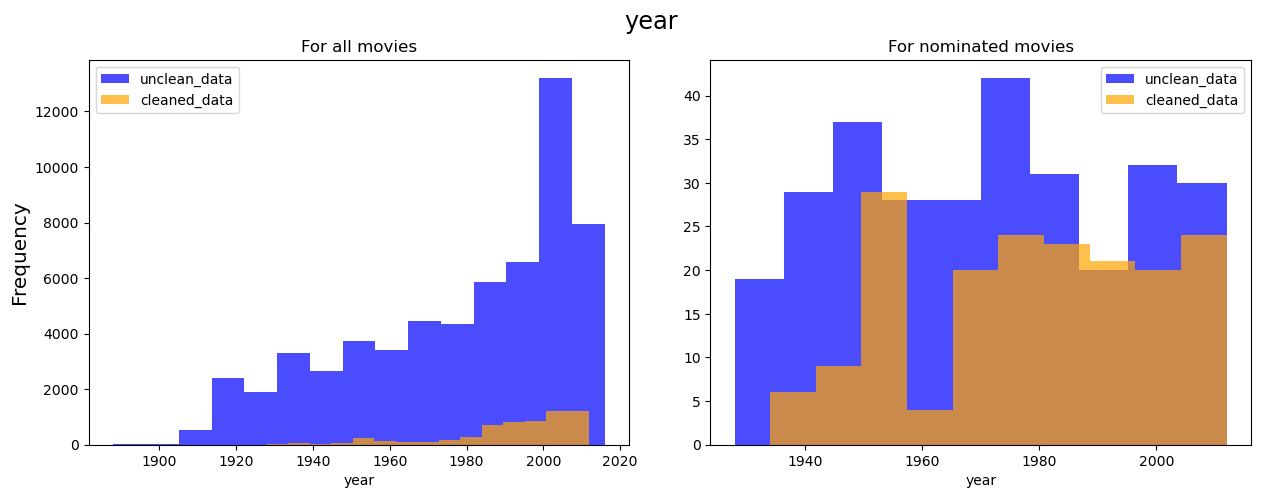

Kolmogorov-Smirnov test for the year distributions before and after data cleaning for all data
Statistic: 0.2671282934762864 ; p-value: 0.0

Kolmogorov-Smirnov test for the year distributions before and after data cleaning for nominated data
Statistic: 0.17552552552552553 ; p-value: 0.0017070034312601594


In [12]:
#To count each movie only once
year_df = df.drop_duplicates(subset='movie_identifier', keep='first')
year_unclean_df = unclean_df.drop_duplicates(subset='movie_identifier', keep='first')

display_cleaning_shift_plot_cont(year_df, year_unclean_df, 'year', "movies", 15, 10, savefile="plots/nandropping_plots/year.jpg")

Removing NaNs alters the distribution of year values for both all the data and nominated data significantly

### Genres

In [13]:
#Create copies for handling country data
genres_df_clean = df.copy()
genres_unclean_df = unclean_df.copy()

#Fix apostrophes in countries column
genres_df_clean['genres'] = df['genres'].apply(lambda row: row.replace("'", '"')).apply(json.loads)
genres_unclean_df['genres'] = unclean_df['genres'].apply(lambda row: row.replace("'", '"')).apply(json.loads)

#Extract all countries associated to a given movie
genres_df_clean = genres_df_clean.explode(column='genres').rename(columns={'genres':'genre'}).reset_index()
genres_unclean_df = genres_unclean_df.explode(column='genres').rename(columns={'genres':'genre'}).reset_index()

#As there appear some movies with genre "," which is not valid, drop those rows
genres_df_clean = genres_df_clean[genres_df_clean['genre'].str.strip() != ","]
genres_unclean_df = genres_unclean_df[genres_unclean_df['genre'].str.strip() != ","]

In [14]:
#Print the most popular genres to plot only them
genres_df_clean['genre'].value_counts()[:10].index

Index(['Drama', 'Comedy', 'Thriller', 'Action', 'Romance Film',
       'Crime Fiction', 'Adventure', 'Romantic comedy', 'Family Film',
       'Indie'],
      dtype='object', name='genre')

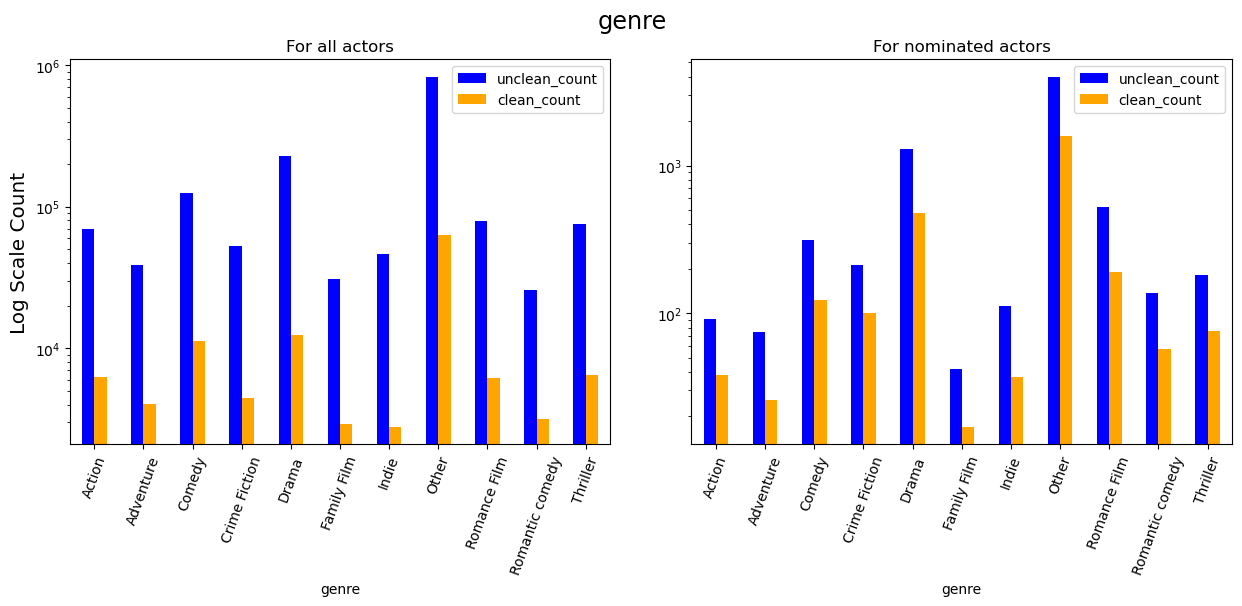

In [15]:
display_cleaning_shift_plot(genres_df_clean, genres_unclean_df, "genre", 
        ['Drama', 'Comedy', 'Thriller', 'Action', 'Romance Film', 'Crime Fiction', 'Adventure', 'Romantic comedy', 'Family Film','Indie'],False, rotation = 70, savefile="plots/nandropping_plots/genres.jpg")

# Analysis

## High-level analysis - Clustering

In [16]:
df = pd.read_parquet('cache/data.parquet')
ethnicities_df = pd.get_dummies(df['actor_ethnicity'], dtype=int, drop_first=True)

In [17]:
x_numeric = df.drop(columns=['languages', 'genres', 'countries', 
                  'title', 'movie_identifier', 'parsed_actor_name', 'actor_identifier', 'identifier', 
                  'category', 'winner', 'oscar_nominated',
                  'actor_gender', 'actor_ethnicity'])
x_numeric['isMale'] = df['actor_gender'].apply(lambda x: 1 if x == 'M' else 0)
all_merged_df = x_numeric.merge(genres_df, left_index=True, right_index=True).merge(languages_df, left_index=True, right_index=True).merge(countries_df, left_index=True, right_index=True)

df['target'] = df.apply(lambda x: make_targets(x['oscar_nominated'], x['winner']), axis=1)

not_nominated = df.loc[df['oscar_nominated'] != True].index
lost = df.loc[(df['oscar_nominated'] == True) & (df['winner'] == False)].index
won = df.loc[(df['oscar_nominated'] == True) & (df['winner'] == True)].index

#### Clustering of actors based on all available numeric features

This includes the augmented features about actors past oscar experience.

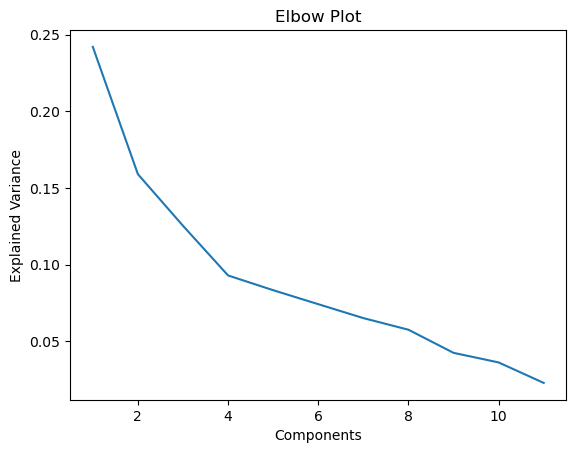

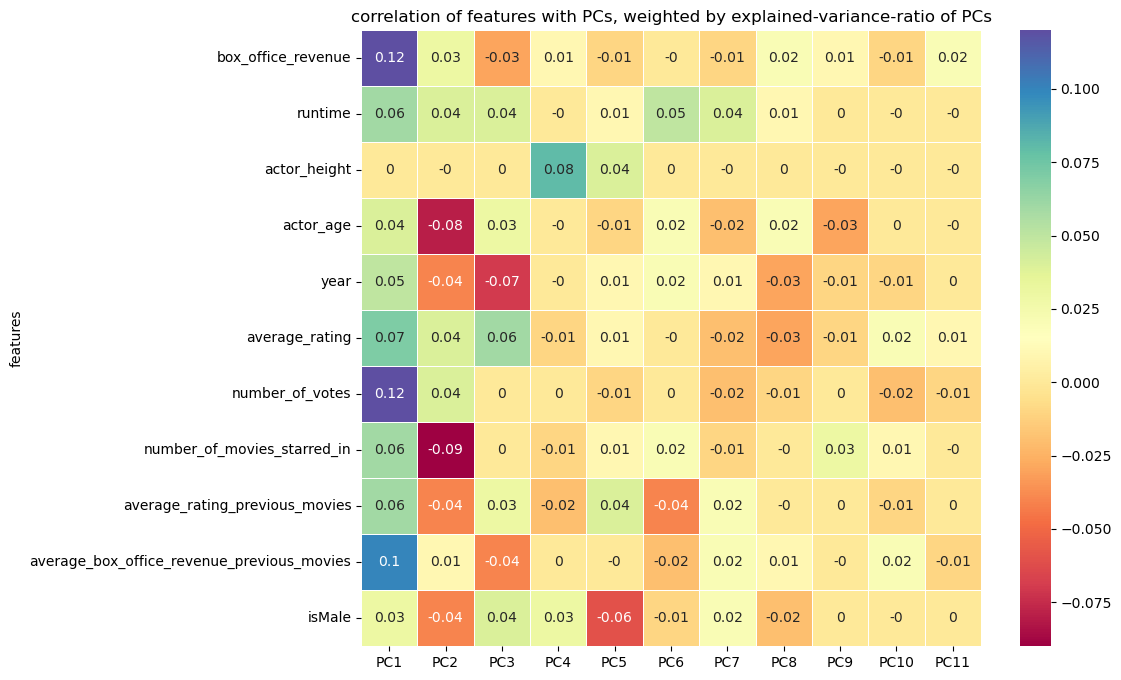

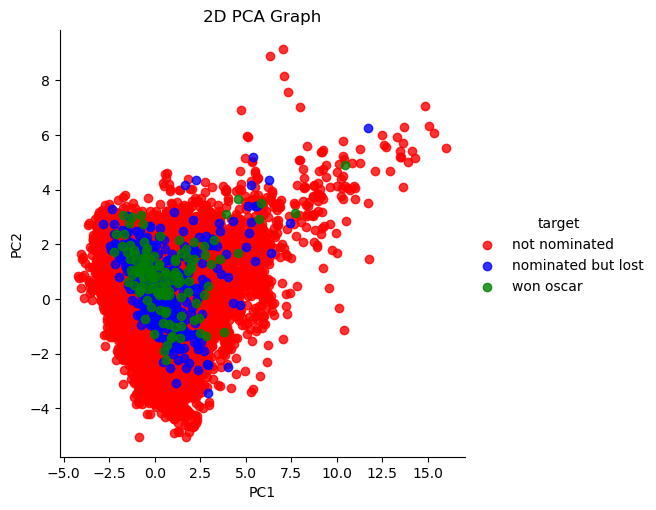

In [18]:
x_numeric_pca_res, x_numeric_pca_out = run_pca_analysis(x_numeric)
elbow_plot(x_numeric_pca_out)
pca_heatmap(x_numeric_pca_out, x_numeric, True, round=2, title='correlation of features with PCs, weighted by explained-variance-ratio of PCs')
pca_scatter_plot(x_numeric_pca_res, df['target'])

## Actor analysis

### Clustering

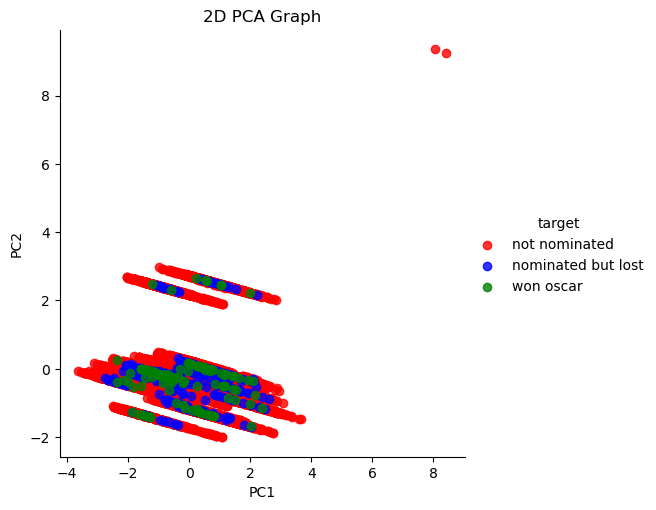

In [19]:
actor_features = pd.DataFrame(x_numeric, columns=['actor_height', 'actor_age', 'isMale',], index=x_numeric.index).merge(ethnicities_df.loc[:, get_top_n_columns_by_sum(ethnicities_df)], left_index=True, right_index=True)

actor_features_pca_res, actor_features_pca_out = run_pca_analysis(actor_features)
pca_scatter_plot(actor_features_pca_res, df['target'])

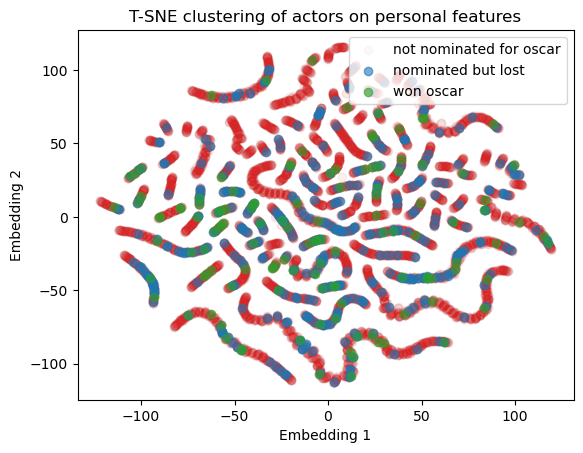

In [20]:
actor_features_tsne_embeddings = run_tsne_analysis(actor_features, 50, scale=True, return_df=True)
plot_clusters(actor_features_tsne_embeddings, not_nominated, lost, won, title=('T-SNE clustering of actors on personal features'))

In [21]:
actor_features = pd.DataFrame(x_numeric, columns=['actor_height', 'actor_age', 'isMale', 'number_of_movies_starred_in', 'average_rating_previous_movies', 'average_box_office_revenue_previous_movies'], index=x_numeric.index).merge(ethnicities_df.loc[:, get_top_n_columns_by_sum(ethnicities_df)], left_index=True, right_index=True)

### Career analysis

#### Network analysis

In [ ]:
import numpy as np
import networkx as nx
from itertools import combinations
import plotly.graph_objects as px

In [ ]:
df_movies = df
oscar_nominated_df = df[df['oscar_nominated']==True]

In [ ]:
# Creating a graph
G = nx.Graph()

# Adding all actors as nodes
for _, row in df_movies.iterrows():
    G.add_node(row['actor_identifier'], oscar_nominated=row['oscar_nominated'])


# Grouping, and for each group add the each combination of actors as an edge
for movie, group in df_movies.groupby('title'):
    actors = group['actor_identifier'].tolist()
    for actor1, actor2 in combinations(actors, 2):
        if G.has_edge(actor1, actor2):
            # Adding an edge 
            G[actor1][actor2]['movies'].append(movie)
        else:
            # If the edge already exists, adding the movie to the list of movies for that edge. 
            G.add_edge(actor1, actor2, movies=[movie])

In [ ]:
# Now we add the degree of each node in two lists based on if they are nominated 
# or not such that we can calculate the average degree of both groups. 
nominated_nodes = []
not_nodes = []
degree_dict = dict(G.degree())
for node, degree in degree_dict.items():
    nominated = G.nodes[node]['oscar_nominated']
    if nominated: 
        nominated_nodes.append(G.degree(node))
    else: 
        not_nodes.append(G.degree(node))

print('Mean edge count for not nominated actors: ', np.round(np.mean(not_nodes),1))
print('Mean edge count for nominated actors: ', np.mean(nominated_nodes))

Nominated actors has almost 2x the relationsships compared to not nominated. We look into this further by comparing number of movie performances for not nominated and not nominated actors. 

In [ ]:
# Defining values for plot. 
temp_df = df[['actor_identifier','oscar_nominated']].groupby('actor_identifier').agg('max').reset_index()
df_with_nominated_status = df.merge(temp_df, on='actor_identifier', how='outer')

oscar_nominated_actors = df_with_nominated_status[df_with_nominated_status['oscar_nominated_y'] == True]
oscar_nominated_actors = oscar_nominated_actors[['actor_identifier', 'number_of_movies_starred_in']].groupby('actor_identifier').agg('max')

not_nominated_actors = df_with_nominated_status[df_with_nominated_status['oscar_nominated_y'] == False]
not_nominated_actors = not_nominated_actors[['actor_identifier', 'number_of_movies_starred_in']].groupby('actor_identifier').agg('max')
oscar_nominated_actors.mean()
not_nominated_actors.mean()

In [ ]:
# Defining values for plot. 
mean_relationships_nominated = np.mean(nominated_nodes)
mean_relationships_not_nominated = np.mean(not_nodes)

In [ ]:
# Plotting 
x = ['Relationships', 'Movie performances']
 
plot = px.Figure(data=[px.Bar(
    name = 'Nominated',
    x = x,
    y = [mean_relationships_nominated,oscar_nominated_actors.mean().values[0]], 
     marker_color='blue'
   ),
    px.Bar(
    name = 'Not nominated',
    x = x,
    y = [mean_relationships_not_nominated, not_nominated_actors.mean().values[0]], 
    marker_color = 'red'
    )
]
)    

plot.update_layout(
    title="Relationships and Performances for nominated and not nominated actors",
    yaxis_title="Number of movies or Relationships",
)

plot.show()

In [ ]:
G = nx.Graph()
for movie, group in oscar_nominated_df.groupby('movie_identifier'):
    actors = group['actor_identifier'].tolist()
    for actor1, actor2 in combinations(actors, 2):
        if G.has_edge(actor1, actor2):
            G[actor1][actor2]['movies'].append(movie)
        else:
            G.add_edge(actor1, actor2, movies=[movie])

In [ ]:
pos = nx.spring_layout(G, k=0.15, iterations=50) 
nx.draw_networkx_nodes(
    G, pos,
    node_color='blue', 
    node_size=35,
    label='Nominated actor'  
)

nx.draw_networkx_edges(
    G, pos,
    width=0.5,
    edge_color='gray', 
    label = 'Actor relation'
)


plt.legend
plt.title('Oscar Nominated Actors')
plt.legend(
    loc='upper left',  
    title="Legend",   
    fontsize='10',
    title_fontsize='12'
)
mpld3.save_html(plt.gcf(), "network_graph.html")

### Modelling on actor features
We will only present our best models

In [22]:
#genres_df = pd.read_parquet('cache/genres.parquet') #This name got overwritten

In [23]:
# Merge data
# Take only relevant columns from the main df (note: left out 'category')
relevant_main_df = df[['box_office_revenue', 'runtime', 'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_age', 'oscar_nominated', 'year', 'average_rating', 'number_of_votes', 'number_of_movies_starred_in', 'average_box_office_revenue_previous_movies']]
modelling_df = pd.concat([relevant_main_df,genres_df, languages_df, countries_df], axis = 1)

#Remove duplicate columns
duplicate_columns = modelling_df.columns[modelling_df.columns.duplicated()]
modelling_df = modelling_df.loc[:, ~modelling_df.columns.duplicated()]

#### Preprocessing data

In [24]:
# Decode ethnicity and one-hot
modelling_df = decode_ethnicity(modelling_df, one_hot = True)

#One-hot encode gender: 1 if woman, no column otherwise
modelling_df["is_woman"] = (modelling_df["actor_gender"] == "F").astype(int)
modelling_df.drop(columns=["actor_gender"], inplace = True)

In [25]:
modelling_df = modelling_df.astype(float) #Change dtype for consistency

#### Correlations

In [26]:
#Gather up all correllations 
nomination_correllations = {}
for col in modelling_df.columns:
    if col != 'oscar_nominated':
        corr, p_value = pearsonr(modelling_df[col], modelling_df['oscar_nominated'])
        nomination_correllations[col] = {'correlation': corr, 'p_value': p_value}
correlations_df = pd.DataFrame.from_dict(nomination_correllations).T

adjusted_p_value = 0.05 / len(correlations_df) #Use the bonferroni correction
significant_correllations_df = correlations_df[correlations_df["p_value"] < adjusted_p_value].sort_values(by="correlation", key=abs, ascending=False)
significant_features = significant_correllations_df.index #Extract for future use
print(f"Nr of significant correllations with being nominated: {len(significant_correllations_df)}")
significant_correllations_df

Nr of significant correllations with being nominated: 55


,correlation,p_value
average_rating,0.169251,1.640400e-152
New Hollywood,0.149198,1.408489e-118
year,-0.137410,1.043556e-100
Drama,0.119307,3.252608e-76
runtime,0.094714,1.396167e-48
Biography,0.076978,1.247714e-32
Comedy,-0.070889,6.481862e-28
Tragedy,0.068748,2.388534e-26
Period piece,0.065439,5.078918e-24
Film adaptation,0.064827,1.329113e-23


#### Modelling from all features

In [27]:
X = modelling_df.drop('oscar_nominated', axis=1)
y = modelling_df['oscar_nominated']
#Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
#Undersample
#Reduce the number of negative samples
sampling_strategy = {False: y_train.value_counts().iloc()[0] // 1, 1: y_train.value_counts().iloc()[1]}
rus = RandomUnderSampler(random_state=42, sampling_strategy = sampling_strategy)

X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

In [29]:
model = tree.DecisionTreeClassifier(random_state=42)
model.fit(X_resampled, y_resampled)

print(f"Trained model depth is {model.get_depth()} ; Number of leaves {model.get_n_leaves()}")
preds = model.predict(X_test)
evaluate_predictions(y_test, preds)

Trained model depth is 32 ; Number of leaves 523
Accuracy: 0.9643082091119043
Precision: 0.2153846153846154
Recall: 0.2916666666666667
F1: 0.24778761061946902


#### Modelling From personal features
Ideally oscars should not discriminate, if it is possible to get nominated based on your personal features, things are not ideal

In [30]:
# Extract features
personal_features_df = df[['actor_gender', 'actor_height', 'actor_ethnicity', 'actor_age', 'oscar_nominated']].copy()
# Decode ethnicity and one-hot
personal_features_df = decode_ethnicity(personal_features_df, one_hot = True)

#One-hot encode gender: 1 if woman, no column otherwise
personal_features_df["is_woman"] = (personal_features_df["actor_gender"] == "F").astype(int)
personal_features_df.drop(columns=["actor_gender"], inplace = True)

personal_features_df = personal_features_df.astype(float)

X = personal_features_df.drop('oscar_nominated', axis=1)
y = personal_features_df['oscar_nominated']

In [31]:
#Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

continuous_cols = ['actor_height', 'actor_age']
# Scaler for features. Fit only to the training data
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(X_train[continuous_cols])

# Transform train and test data according to the scaler (only continuous columns)
X_train[continuous_cols] = scaler.transform(X_train[continuous_cols]) 
X_test[continuous_cols] = scaler.transform(X_test[continuous_cols])

# Add constants to train and test set
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

#Oversample
sampling_strategy = {False: y_train.value_counts().iloc()[0], 1: y_train.value_counts().iloc()[1] * 40}
ros = RandomOverSampler(random_state=42, sampling_strategy = sampling_strategy)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [32]:
model = sm.Logit(y_resampled, X_resampled.astype(float))
#result = model.fit()
#preds = result.predict(X_test)
#find_optimal_cutoff(y_test, preds, cutoffs)

## Film analysis

### Nationality

In [38]:
# Getting dataframes of all nominated movies with the "countries"-column exploded (meaning we have one row per actor/movie/country combination)
# exploded_df contains all rows in the dataset exploded by country, nominated_df contains all rows from exploded_df that were nominated for an Oscar
nominated_df, exploded_df = get_nationality_dfs(df)

Number of rows, including those with multiple nationalities: 23812


We plot the 10 countries with the most Oscar nominations:

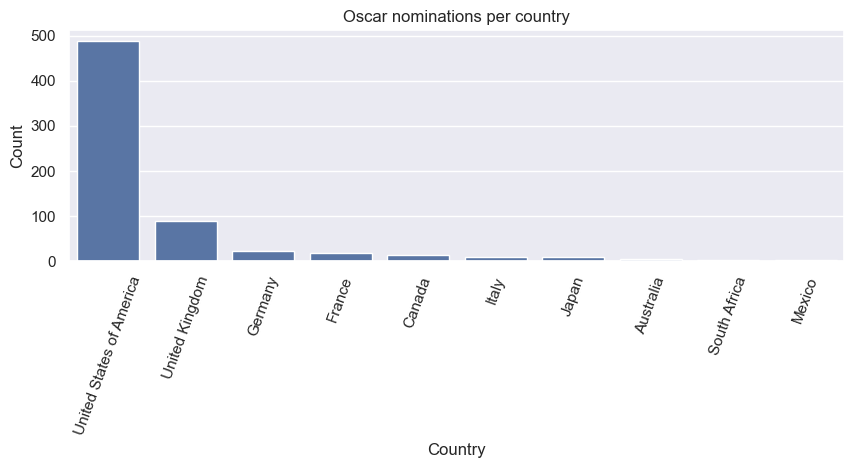

In [40]:
sns.set_theme(rc={'figure.figsize':(10, 3)})
plt.xticks(rotation=70)
plt.ylabel('Count')
plt.xlabel('Country')
plt.title('Oscar nominations per country')
sns.countplot(x='country', data=nominated_df, order=nominated_df['country'].value_counts()[:10].index);
plt.savefig('plots/oscar-nom-per-country.png', bbox_inches='tight')

We see that the USA is vastly overrepresented. We combine all countries other than the USA and UK into an "others" category

In [41]:
others_df = nominated_df.copy()
# Replace countries other than USA or UK with "Others"
others_df['country'] = others_df['country'].apply(lambda country: country if country in ['United States of America', 'United Kingdom'] else 'Others')

# We drop duplicates to ensure that the same movie won't be counted multiple times for Others
others_df = others_df.drop_duplicates(subset=['country', 'identifier'])

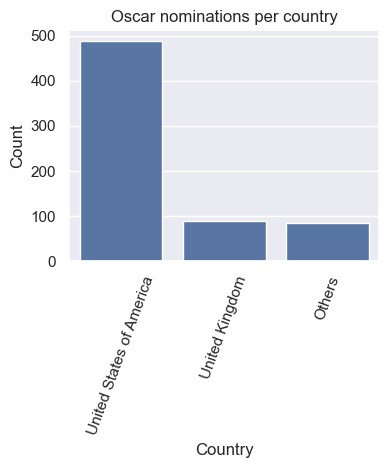

In [42]:
sns.set_theme(rc={'figure.figsize':(4, 3)})
plt.xticks(rotation=70)
plt.ylabel('Count')
plt.xlabel('Country')
plt.title('Oscar nominations per country')
sns.countplot(x='country', data=others_df, order=others_df['country'].value_counts()[:10].index);
plt.savefig('plots/oscar-nom-per-country-others.png', bbox_inches='tight')

In [43]:
# Get series of countries with their number of nominations adjusted for total number of rows in the dataset. Gives us some idea of the probability of a row from a country being nominated
exploded_others_df = exploded_df.copy()

# Replace countries except USA and UK with "Others"
exploded_others_df['country'] = exploded_df['country'].apply(lambda country: country if country in ['United States of America', 'United Kingdom'] else 'Others')

# Drop duplicates of same country and identifier, otherwise one nomination from multiple "Others"-countries would be counted multiple times
exploded_others_df = exploded_others_df.drop_duplicates(subset=['country', 'identifier'])

# Get the adjusted nominations
adjusted_nominations = get_adjusted_nominations(exploded_others_df, others_df)

Plot Oscar nominations for the USA, UK and "Others" after adjustment by total number of movies from the respective categories:

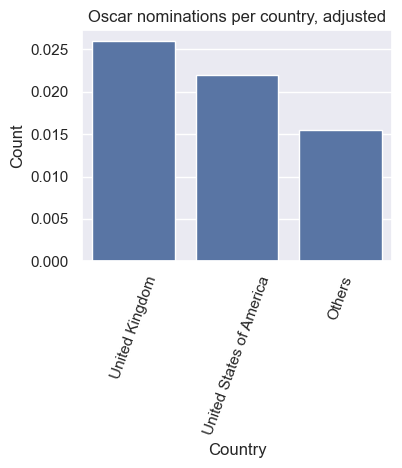

In [44]:
sns.set_theme(rc={'figure.figsize':(4,3)})
plt.xticks(rotation=70)
plt.ylabel('Count')
plt.xlabel('Country')
plt.title('Oscar nominations per country, adjusted')
sns.barplot(data = adjusted_nominations.sort_values(ascending=False)[:10]);
plt.savefig('plots/oscar-nom-per-country-adjusted.png', bbox_inches='tight')

To our surprise, the USA is no longer on top! Actually, it performs pretty average when adjusted by the total number of movies.

In general, this analysis is very affected by our data cleaning process. For example, as documented in the data pipeline, we drop most actor/movie rows from India (Which means that we basically disregard Bollywood in this analysis, even though Bollywood would very likely have introduced a significant shift in the Oscard nomination probabilities). Keeping this in mind, we move on to analyze the distribution of American vs. non-American movies in our dataset.

#### Binomial test USA vs. non-USA

In [53]:
df["is_american"] = df.apply(lambda x : "United States of America" in x["countries"], axis = 1)

In [57]:
# movie_character_oscar_rating_df contains a row for each actor/movie pair. We select the non-American actors and compare with the American actors

# All actors/movie rows, American and non-American
total_actors_num = len(df['countries'])
american_total_actors_num = len(df[df['is_american']])
non_american_total_actors_num = total_actors_num - american_total_actors_num

# All actors/movie rows with an Oscar nomination, American and non-American
total_nominated_actors_num = len(df[df['oscar_nominated'] == True]['countries'])
american_nominations_num = len(df[(df['is_american']) & (df['oscar_nominated'] == True)])
non_american_nominations_num = total_nominated_actors_num - american_nominations_num

In [58]:
# Observed probability of American actor getting nominated for a film
p_american = american_nominations_num / american_total_actors_num
p_non_american = non_american_nominations_num / non_american_total_actors_num

# We perform a two-sided hypothesis test for whether non-American actors have the same binomial probability of getting nominated as American ones
stats.binomtest(non_american_nominations_num, non_american_total_actors_num, p_american)

BinomTestResult(k=32, n=1644, alternative='two-sided', statistic=0.019464720194647202, pvalue=0.5555726270675672)

Using alpha=0.05. P-value=0.56 > 0.05. The conclusion from this is that American movies in our dataset do not have a significantly different probability of being nominated for Oscars. Again, this is likely due to our data cleaning, where we remove for example a lot of Indian rows that had NaN-values (And were also likely not Oscar nominated).

In [59]:
print('Fraction of American actors nominated for an Oscar:',round(p_american, 5))
print('Fraction of non-American actors nominated for an Oscar:', round(p_non_american, 5))

Fraction of American actors nominated for an Oscar: 0.02197
Fraction of non-American actors nominated for an Oscar: 0.01946


While the probability of winning an Oscar in general is likely higher for American movies, **we will keep the non-American movies in this dataset**, as the cleaning seems to have removed the expected multicolinearity between country and Oscar nomination.

#### Binomial test on dataset before cleaning

The nationality analysis does not affect how we treat our dataset moving forward, but it is also interesting to examine how nationality relates to chances of Oscar nomination before we remove null-values (that is, how does it relate to the whole combined dataset before cleaning?). We perform the same binomial analysis on the uncleaned data.

In [ ]:
unclean_df["is_american"] = unclean_df.apply(lambda x : "United States of America" in x["countries"], axis = 1)

In [ ]:
# movie_character_oscar_rating_df contains a row for each actor/movie pair. We select the non-American actors and compare with the American actors

# All actors/movie rows, American and non-American
total_actors_num = len(unclean_df['countries'])
american_total_actors_num = len(unclean_df[unclean_df['countries'].str.contains('United States of America')])
non_american_total_actors_num = total_actors_num - american_total_actors_num

# All actors/movie rows with an Oscar nomination, American and non-American
total_nominated_actors_num = len(unclean_df[unclean_df['oscar_nominated'] == True]['countries'])
american_nominations_num = len(unclean_df[(unclean_df['countries'].str.contains('United States of America')) & (unclean_df['oscar_nominated'] == True)])
non_american_nominations_num = total_nominated_actors_num - american_nominations_num

In [ ]:
# Observed probability of American actor getting nominated for a film
p_american = american_nominations_num / american_total_actors_num
p_non_american = non_american_nominations_num / non_american_total_actors_num

print(f"Share of American movies being nominated: {p_american}")
print(f"Share of non-American movies being nominated: {p_non_american}")

# We perform a two-sided hypothesis test for whether non-American actors have the same binomial probability of getting nominated as American ones
stats.binomtest(non_american_nominations_num, non_american_total_actors_num, p_american)

Using alpha=0.05, this p-value is far below our alpha. This indicates a significantly different distribution.

We see that the same test performed on the full dataset before dropping null-values shows a significantly higher chance for American movies to be nominated than non-American movies. Assuming that the complete dataset is representative of the real world, we conclude that actors in American movies in general have a much higher chance of being nominated for an Oscar compared to actors in non-American movies.

### Genre analysis

In [ ]:
# Making a copy for this part
genre_df = df.copy()
genre_df_new = df.copy()
genre_df_new = genre_df_new[genre_df_new['year'] > 1999]

# One nan value, filling with no genres, i.e. [] 
genre_df['genres'] = genre_df['genres'].fillna('[]')
genre_df_new['genres'] = genre_df_new['genres'].fillna('[]')


# Splitting each entry in the genre column into lists of genres. 
genre_lists = genre_df['genres'].apply(lambda x: x[1:-1].split(', ') if x != '[]' else [])
genre_lists_new = genre_df_new['genres'].apply(lambda x: x[1:-1].split(', ') if x != '[]' else [])

# Removing "" from each list in genre_lists: "'Thriller'" -> 'Thriller'
genre_lists = genre_lists.apply(lambda x: [g[1:-1] for g in x])
genre_lists_new = genre_lists_new.apply(lambda x: [g[1:-1] for g in x])


# Removing emtpy entries in the lists: 
genre_lists = genre_lists.apply(lambda x: [g for g in x if g != ''] )
genre_lists_new = genre_lists_new.apply(lambda x: [g for g in x if g != ''] )


# Creating a set of all genres. 
all_genres = set([genre for sublist in genre_lists for genre in sublist])
all_genres_new = set([genre for sublist in genre_lists_new for genre in sublist])


# Resetting index
genre_df = genre_df.reset_index(drop=True)
genre_df_new = genre_df_new.reset_index(drop=True)

In [ ]:
# Adding all genres as keys to the dictionary
genre_dict = {}
for g in all_genres:
    genre_dict[g] = []

genre_dict_new = {}
for g in all_genres_new: 
    genre_dict_new[g] = []

# For each movie, for each genre, we append a 1 if the genre was in the movie, else 0
for movie_genres in genre_lists:  
    for g in all_genres:
        if g in movie_genres: 
            genre_dict[g].append(1)
        else: genre_dict[g].append(0)

for movie_genres in genre_lists_new:  
    for g in all_genres_new:
        if g in movie_genres: 
            genre_dict_new[g].append(1)
        else: genre_dict_new[g].append(0)

In [ ]:
# Each genre has now a list indicating if what movies has that genre
print('Length: ', len(genre_dict['Thriller']))
print(genre_dict['Thriller'][:10])

In [ ]:
genre_df['genres'].head()

In [ ]:
genre_df = pd.concat([genre_df.reset_index(drop=True), pd.DataFrame(genre_dict).reset_index(drop=True)], axis=1)
genre_df_new = pd.concat([genre_df_new.reset_index(drop=True), pd.DataFrame(genre_dict_new).reset_index(drop=True)], axis=1)

In [ ]:
# making a version containing only movies with nominated performances
genre_df_oscar_nominated = genre_df[genre_df['oscar_nominated'] == True]
genre_df_new_oscar_nominated = genre_df_new[genre_df_new['oscar_nominated'] == True]

In [ ]:
print('Nr. of columns in new df: ', genre_df_oscar_nominated.columns.shape)
print('Example genres: ', genre_df_oscar_nominated.columns[100:104].values)

In [ ]:
genre_frequencies = genre_df.iloc[:,23:].sum(axis=0).sort_values(ascending=False)
genre_frequencies_new = genre_df_new.iloc[:,23:].sum(axis=0).sort_values(ascending=False)


nominated_genre_frequencies = genre_df_oscar_nominated.iloc[:,23:].sum(axis=0)
nominated_genre_frequencies = nominated_genre_frequencies.reindex(genre_frequencies.index)

nominated_genre_frequencies_new = genre_df_new_oscar_nominated.iloc[:,23:].sum(axis=0)
nominated_genre_frequencies_new = nominated_genre_frequencies_new.reindex(genre_frequencies_new.index)

In [ ]:
assert nominated_genre_frequencies.index.all() == genre_frequencies.index.all()
assert nominated_genre_frequencies_new.index.all() == genre_frequencies_new.index.all()

In [ ]:
genre_frequencies_df = pd.DataFrame({'all': genre_frequencies, 'nominated': nominated_genre_frequencies})
genre_frequencies_new_df = pd.DataFrame({'all': genre_frequencies_new, 'nominated': nominated_genre_frequencies_new})

In [ ]:
# Creating a new column that will be true if it has no nominated appearances. 
genre_frequencies_df['top_non_nominated_genres'] = False
mask = genre_frequencies_df['nominated'] == 0
genre_frequencies_df.loc[mask, 'top_non_nominated_genres'] = True
# Selecting all the genres that does not have any nominated appearances and saving to not_nominated_genres_df. 
not_nominated_genres_df = genre_frequencies_df.loc[genre_frequencies_df['top_non_nominated_genres'] == True,:].reset_index()
not_nominated_genres_df = not_nominated_genres_df.rename(columns={'index':'genre'})
print(not_nominated_genres_df.head())
print(not_nominated_genres_df.shape)

116 Genres have no oscar nominated actors. Some of these genres are self explanatory e.g. Animation. However we need further analysis to get a deeper understanding. 

In [ ]:
# Adding a new columns
genre_frequencies_df['share_nominated'] = genre_frequencies_df['nominated'] / genre_frequencies_df['all']
# Sorting the dataframe on nominated movies after removing the genres with 1 nomination. 
genre_frequencies_df = genre_frequencies_df[genre_frequencies_df['nominated'] > 1].sort_values(by='nominated', ascending=False)
# Selecting top 20 genres by the nr. of nominated movies in that genre
top_20_df = genre_frequencies_df.iloc[:20,:].sort_values(by='nominated', ascending=False)

In [ ]:
# Plotting 
fig = go.Figure()

fig.add_trace(
    go.Bar(
        y=not_nominated_genres_df.loc[:20,'genre'],  
        x=not_nominated_genres_df.loc[:20,'all'],     
        orientation='h',  
        name="Number of performances. 1928-2012",
        text=not_nominated_genres_df.loc[:20,'all'], 
        textposition='outside',
        marker=dict(color='blue'), 
        opacity=0.7   
    ),
)

fig.update_layout(
    title='Biggest genres without Oscar nominated performance',
    xaxis_title='Nr. of performances',
    yaxis_title='Genres',
    barmode='stack',  
    template='plotly',  
    showlegend=True     
)
fig.show()
fig.write_html('genres_wo_nominations.html', full_html=False, include_plotlyjs='cdn')


There are clearly genres worth avoiding for oscar aspiring actors. For instance Absurdims, doomsday film, dystopia and holiday film to name a few. On the otherhand, there are also genres that have many actor nominations, e.g. Drama, Period, Romantic drama and Biography. However, they have many nominations partly because they have many movies. Hence, we can look at the genres with the highest share of oscar winners. 

In [ ]:
genre_frequencies_df = genre_frequencies_df[genre_frequencies_df['nominated'] > 1].sort_values(by='nominated', ascending=False)
# Selecting top 20 genres by the share of nominated performances
top_20_df = genre_frequencies_df.iloc[:20,:].sort_values(by='share_nominated', ascending=False)
# Converting to %
top_20_df['%_nominated'] = top_20_df['share_nominated']*100
# Selecting top 20 genres by the share of nominated performances
top_20_df = genre_frequencies_df.iloc[:20,:].sort_values(by='share_nominated', ascending=False)
# Converting to %
top_20_df['%_nominated'] = top_20_df['share_nominated']*100

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    y=top_20_df.index,   
    x=top_20_df['%_nominated'], 
    orientation='h',
    name='% of performances nominated',
    marker=dict(color='blue'), 
    xaxis='x1', 
))

fig.add_trace(go.Bar(
    y=top_20_df.index,   
    x=top_20_df['all'], 
    orientation='h',
    name='Performances',
    marker=dict(color='red'), 
    xaxis='x2'  
))

fig.update_layout(
    title='Top genres at the Oscars',
    xaxis_title='% of performances nominated', 
    yaxis_title='Genres', 
    barmode='stack', 
    template='plotly',  
    showlegend=True,
    
    xaxis=dict(
        title='% of performances nominated',
        range = [0,40], 
        overlaying='x2',
        
    ),
    
    xaxis2=dict(
        title='Performances',  
        side='top'  
        
    )
)
fig.write_html('genres_by_share2.html', full_html=False, include_plotlyjs='cdn')
fig.show()

The genre with the highest share of oscar nominated performances is New Hollywood with 27% of performances being nominated. Coming second is Biographical film with only 8% of performances being nominated. With a time machine, travelling back to the 1960s-1980s would be the most optimal for an actor winning an oscar. Hence we will need to look at more recent successful genres. 

In [ ]:
# Selecting top 20 genres by the share of nominated performances
top_20_df = genre_frequencies_new_df.iloc[:20,:].sort_values(by='share_nominated', ascending=False)
# Converting to %
top_20_df['%_nominated'] = top_20_df['share_nominated']*100

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    y=top_20_df.index,   
    x=top_20_df['%_nominated'], 
    orientation='h',
    name='% of performances nominated',
    marker=dict(color='blue'), 
    xaxis='x1', 
))

fig.add_trace(go.Bar(
    y=top_20_df.index,   
    x=top_20_df['all'], 
    orientation='h',
    name='Performances',
    marker=dict(color='red'), 
    xaxis='x2'  
))

fig.update_layout(
    title='Top genres at the Oscars since 2000',
    xaxis_title='% of performances nominated', 
    yaxis_title='Genres', 
    barmode='stack', 
    template='plotly',  
    showlegend=True,
    
    xaxis=dict(
        title='% of performances nominated',
        range = [0,40], 
        overlaying='x2',
        
    ),
    
    xaxis2=dict(
        title='Performances',  
        side='top'  
        
    )
)
fig.write_html('genres_by_share_new.html', full_html=False, include_plotlyjs='cdn')
fig.show()

### Modelling on movie features

In [ ]:
opinion_df = df[['movie_identifier','actor_identifier','identifier','actor_gender','category', 'winner', 'oscar_nominated', 'average_rating', 'number_of_votes', 'box_office_revenue']]

#### Correllations

In [ ]:
#Since the ratings are movie based, refactor data like so for general corellation measuring:
#Take one line for each movie. If that movie was nominated at least once, oscar_nominated = 1, else 0
nominated_movies = opinion_df[opinion_df['oscar_nominated'] == True]
#Add nominated movies to the top to ensure that the movies kept are first
each_movie_once_df = pd.concat([nominated_movies, opinion_df], axis=0)

each_movie_once_df = each_movie_once_df.drop_duplicates(subset='movie_identifier', keep='first')

In [ ]:
sns.lineplot(data=each_movie_once_df, x="average_rating", y="oscar_nominated")
plt.ylabel("Probability of being nominated")
plt.xlabel("Movie average rating")
plt.title("Probability of being nominated from average rating\nWith confidence interval")
plt.savefig("avg_rating_nominated")
plt.plot();

It is pretty well seen, that in general, with the average rating rising the chances to be nominated do as well. As the upper area of average ratings is rarer, the model becomes more unpredictable.

It is also noteworthy that the confindence interval when the probability of nomination is bigger is very large, meaning that the true mean of the probability could be 0 or 1. Overall though, the probability is quite clearly trending upwards with the average rating

In [ ]:
each_movie_once_df['binned_nr_votes'] = pd.cut(each_movie_once_df['number_of_votes'], bins=10)
binned_data = each_movie_once_df.groupby('binned_nr_votes', observed=False)['oscar_nominated'].mean().reset_index()
binned_data['binned_nr_votes'] = binned_data['binned_nr_votes'].apply(lambda x: x.mid)

sns.lineplot(data=binned_data, x='binned_nr_votes', y="oscar_nominated", marker="o")
plt.ylabel("Probability of being nominated")
plt.xlabel("Number of votes binned")
plt.title("Probability of being nominated from number of votes binned")
plt.savefig("nr_votes_nominated")
plt.plot();

Notebly the number of votes a movie got also seems to be positively correlated with its odds of being nominated. This is likely due to the movies nominated having a lot of publicity and hence receiving more votes

In [ ]:
each_movie_once_df['binned_box_office'] = pd.cut(each_movie_once_df['box_office_revenue'], bins=13)
binned_data = each_movie_once_df.groupby('binned_box_office', observed=False)['oscar_nominated'].mean().reset_index()
binned_data['binned_box_office'] = binned_data['binned_box_office'].apply(lambda x: x.mid)

sns.lineplot(data=binned_data, x='binned_box_office', y="oscar_nominated", marker="o")
plt.ylabel("Probability of being nominated")
plt.xlabel("Box office revenue")
plt.title("Probability of being nominated from Box office revenue\nWith confidence interval")
plt.plot();

Box office score does not seem to have a huge positive correllation. Again as the high-value scores are rare, the jumps in probability are bound to happen. Though somewhat suprisingly the lower box-score movies have around equal chances of winning

#### logistic regression

In [ ]:
X = each_movie_once_df[['average_rating', 'number_of_votes', 'box_office_revenue']].astype(float)
y = each_movie_once_df[['oscar_nominated']].astype(float)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

result = log_regression(X_train, X_test, y_train, y_test)

In [ ]:
#Evaluate
output = result.predict(sm.add_constant(X_test))
#Find the statistics with the best cutoff point
find_optimal_cutoff(y_test, output)

The data is way too imbalanced to work. With every possible cutoff at most 1 test instance gets classified to be nominated. Attempting with data rebalancing

#### Decision tree

In [ ]:
model = tree.DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train.values.ravel())
print(f"Trained model depth is {model.get_depth()} ; Number of leaves {model.get_n_leaves()}")

In [ ]:
output = model.predict(X_test)
#Evaluation
evaluate_predictions(y_test, output)

Decision tree is able to solve this problem somewhat, although not with the perhaps desired accuracy. Additionally, the model trained has a huge complexity, even though it only posessed 2 features. This could indicate the model hardcoding a path for all instances and not finding any true patterns

# Conclusion